## GMM with circular_feature_transforms


In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer

In [8]:
# Constants
ANOMALY_THRESHOLD = 3

## Functions to perform Linear to Circular Feature transforms
In our existing GMM, we will now need 2 circular representation for each linear feature. So our feature vector will become 2x4 = 8 from current 4

In [14]:
# convert lat, long to radians
def lat_long_to_radians(lat_long):
    return np.radians(lat_long)


# convert radians back to lat, long
def radians_to_lat_long(radians):
    return np.degrees(radians)


# transform time of day and day of week to sin, cos
def time_transform(time_day):
    time, day = time_day[:, 0], time_day[:, 1]
    time_rad = np.radians(time * 24 / 360)  # Convert time to radians
    day_rad = np.radians(day * 2 * np.pi / 7)  # Convert day to radians (circular encoding)
    return np.column_stack((np.sin(time_rad), np.cos(time_rad), np.sin(day_rad), np.cos(day_rad)))


# reverse the time transformation
def reverse_time_transform(transformed_time):
    time_sin, time_cos, day_sin, day_cos = transformed_time[:, 0], transformed_time[:, 1], transformed_time[:, 2], transformed_time[:, 3]
    time_rad = np.arctan2(time_sin, time_cos)
    day_rad = np.arctan2(day_sin, day_cos)
    time = np.degrees(time_rad) * 360 / 24
    day = np.degrees(day_rad) * 7 / (2 * np.pi)  # Circular decoding
    return np.column_stack((time, day))


# Extract time of day and day of week from epoch milliseconds
def epochmillis_to_time_day(epochmillis):
    time_of_day = np.array([datetime.datetime.fromtimestamp(m[0] / 1000).hour + datetime.datetime.fromtimestamp(m[0] / 1000).minute / 60 for m in epochmillis])
    day_of_week = np.array([datetime.datetime.fromtimestamp(m[0] / 1000).weekday() for m in epochmillis])
    return np.column_stack((time_of_day, day_of_week))


## Plot GMM clusters

In [21]:
def plot_gmm(gmm, data, lat_long_data=None, anomalies=None):

    fig = plt.figure(figsize=(12, 6))
    # Plot 3D features (lat, long, time) with color representing day of week
    ax = fig.add_subplot(111, projection='3d')
    if anomalies is not None:
        ax.scatter(anomalies[:, 0], anomalies[:, 1], anomalies[:, 2], c='black', marker='x', alpha=0.5)
    colors = ['r', 'g', 'b', 'y', 'm', 'c', 'k']  # 7 colors for 7 days
    for i in range(7):
        day_data = data[data[:, 5] == i]  # Select data for current day
        ax.scatter(day_data[:, 0], day_data[:, 1], day_data[:, 2], c=colors[i], alpha=0.5)

    # Plot GMM clusters as ellipsoids
    for i, covar in enumerate(gmm.covariances_):
        # Extract the 3D covariance matrix for the current component
        covar_mat = covar[:3, :3]
        # Calculate the eigenvalues and eigenvectors of the covariance matrix
        eigenvals, eigenvecs = np.linalg.eig(covar_mat)
        # Calculate the radii of the ellipsoid
        radii = np.sqrt(eigenvals)
        # Calculate the orientation of the ellipsoid
        orientation = eigenvecs
        # Plot the ellipsoid
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = radii[0] * np.outer(np.cos(u), np.sin(v)) + gmm.means_[i, 0]
        y = radii[1] * np.outer(np.sin(u), np.sin(v)) + gmm.means_[i, 1]
        z = radii[2] * np.outer(np.ones(np.size(u)), np.cos(v)) + gmm.means_[i, 2]
        ax.plot_surface(x, y, z, color='red', alpha=0.2)

    plt.show()



##  Identify anomalies using Mahalanobis distance

In [22]:
def identify_anomalies(gmm, data):
    """
    Calculate Mahalanobis distance for each component of the GMM and
    then take the minimum distance across all components.
    """
    
    distances = []
    
    for mean, covar in zip(gmm.means_, gmm.covariances_):
        # Calculate the Mahalanobis distance for each component
        delta = data - mean
        mahalanobis_dist = np.sqrt(np.diag(delta @ np.linalg.inv(covar) @ delta.T))
        distances.append(mahalanobis_dist)

    # Calculate the overall Mahalanobis distance as the minimum distance across all components
    distances = np.min(distances, axis=0)

    # Our current ANOMALY_THRESHOLD in cyglass implementation is 5. But once we switch to circular 
    # transform, we can switch to ANOMALY_THRESHOLD=3 as here.. Still need to test
    
    threshold = np.mean(distances) + ANOMALY_THRESHOLD * np.std(distances)
    anomalies = data[distances > threshold]
    return anomalies


In [25]:
def bic_scorer(estimator, X):
    covariances = estimator.covariances_
    weights = estimator.weights_
    n_components = estimator.n_components
    n_samples, n_features = X.shape
    log_likelihood = estimator.score(X)
    bic = -2 * log_likelihood + n_components * (n_features * (n_features + 1) / 2 + 1) * np.log(n_samples)
    return -bic  # Note the minus sign, as GridSearchCV maximizes the score


/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'


/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'


/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'


TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/anroy/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(e

Best Parameters: {'covariance_type': 'full', 'init_params': 'kmeans', 'n_components': 2}
Best BIC Score: nan


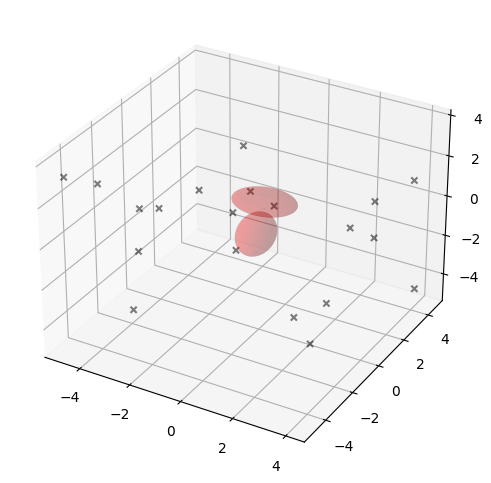

Silhouette Score: 0.24159860611951967
Anomalies:
[[-0.92569732  1.34726454 -1.70123744  1.13505233  1.6394473  -2.0534522 ]]
Decoded Anomalies:
[[-98.50601632 155.9203889    0.55         6.        ]]


In [26]:
if __name__ == '__main__':

    # Initial data
    initial_lat_long = np.random.uniform(-180, 180, size=(100, 2))
    initial_epochmillis = np.random.uniform(1643723400000, 1646315200000, size=(100, 1))
    initial_time_day = epochmillis_to_time_day(initial_epochmillis)

    # Transform initial data
    initial_lat_long_rad = lat_long_to_radians(initial_lat_long)
    initial_time_day_transformed = time_transform(initial_time_day)
    initial_data = np.column_stack((initial_lat_long_rad, initial_time_day_transformed))

    # Standardize data
    scaler = StandardScaler()
    initial_data_standardized = scaler.fit_transform(initial_data)

    # Perform grid
    # Define hyperparameter grid
    param_grid = {
        'n_components': [2, 3, 4, 5],
        'covariance_type': ['full', 'tied', 'diag'],
        'init_params': ['kmeans', 'random']
    }

    # Perform grid search for hyperparameter tuning
    gmm = GaussianMixture(random_state=42)
    bic_scorer_ = make_scorer(bic_scorer, greater_is_better=False)

    grid_search = GridSearchCV(gmm, param_grid, cv=5, scoring=bic_scorer_, n_jobs=-1)
    grid_search.fit(initial_data_standardized)

    # Print best hyperparameters and BIC score
    print("Best Parameters:", grid_search.best_params_)
    print("Best BIC Score:", grid_search.best_score_)

    # Train GMM model with best hyperparameters
    best_gmm = grid_search.best_estimator_
    best_gmm.fit(initial_data_standardized)

    # Plot initial GMM clusters
    #plot_gmm(best_gmm, initial_data_standardized, lat_long_data=initial_lat_long)
    # Plot initial GMM clusters with anomalies
    anomaly_data = np.random.uniform(-5, 5, size=(20, 6))
    plot_gmm(best_gmm, initial_data_standardized, lat_long_data=initial_lat_long, anomalies=anomaly_data)

    # Predict cluster labels
    cluster_labels = best_gmm.predict(initial_data_standardized)

    # Evaluate model performance using silhouette score
    silhouette = silhouette_score(initial_data_standardized, cluster_labels)
    print("Silhouette Score:", silhouette)

    # Identify anomalies
    anomalies = identify_anomalies(best_gmm, initial_data_standardized)

    # Print anomalies
    print("Anomalies:")
    print(anomalies)

    # Decode anomalies back to original input
    decoded_anomalies = scaler.inverse_transform(anomalies)
    decoded_anomalies_lat_long = radians_to_lat_long(decoded_anomalies[:, :2])
    decoded_anomalies_time_day = reverse_time_transform(decoded_anomalies[:, 2:])
    print("Decoded Anomalies:")
    print(np.column_stack((decoded_anomalies_lat_long, decoded_anomalies_time_day)))
